# Comprehensive Experiment Data Analysis

##### Note(7/20)
Containing results from three conditioned datesets, with gaussian, median, blackout and destroy-bg ablations. 
Tabled statistics: https://docs.google.com/document/d/1dkbPI0PF8lcrVz4LOKOHBviCjfrji1E6mlKrQdV2fHI/edit?ts=5788e509#


In [1]:
CWD = %pwd
CWD = str(CWD)
import sys
import json
from six.moves import cPickle
import os
import statistics
from collections import defaultdict,Iterable

from IPython.core.display import HTML 
from IPython.core.display import Image, display, display_pretty

import numpy as np
from scipy import misc, polyfit, stats
import matplotlib.pyplot as plt
import PIL
# from PIL import Image
%matplotlib inline  


COCO_PATH = os.path.join(CWD,'data','coco')
COCO_ANNO_PATH = os.path.join(COCO_PATH, 'annotations')
COCO_TEXT_PATH = os.path.join(CWD, 'coco-text')
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct
ct = ct.COCO_Text(os.path.join(COCO_PATH, 'COCO_Text.json'))
import ablation
sys.path.insert(0, os.path.join(CWD, 'coco', 'PythonAPI'))
from pycocotools.coco import COCO,mask

loading annotations into memory...
0:00:02.996547
creating index...
index created!
/Users/zhuyifan/Documents/2016 Summer Research/textmatters/coco-text
loading annotations into memory...
Done (t=21.93s)
creating index...
index created!


In [2]:
"""
Load Coco data
"""

# load the data from captions
with open(COCO_ANNO_PATH + '/captions_train2014.json') as f:
    coco_captions = json.load(f)
# print len(coco_captions)
# with open(COCO_ANNO_PATH + 'captions_val2014.json') as f:
#     coco_captions =  dict(coco_captions.items() + json.load(f).items())
# print len(coco_captions)

# build the reverse dictionary, from img_id to captions, img_infos, and annotations
img_captions = {}
for img_info in coco_captions['images']:
    mid = str(img_info['id'])
    if not mid in img_captions:
        img_captions[mid] = {}
    img_captions[mid]['image'] = img_info

for cap_info in coco_captions['annotations']:
    mid = str(cap_info['image_id'])
    if not 'annotation' in img_captions[mid]:
        img_captions[mid]['annotation'] = []
        img_captions[mid]['captions'] = []
    img_captions[mid]['annotation'].append(cap_info)


In [18]:
IN_FILE_NAME  = 'scores_no_rel_texts_blackout.pkl'
OUT_FILE_NAME = 'no_rel_texts_img_ids'
IN_DIR        = 'input'
OUT_DIR       = 'output'

import random

def pre_process_vis(vis, scores, l):
    """Since with large batch size, vis.json might contain duplicates. This function will purge out the duplicates.
    l is the number of image ids used to generate vis. After filtering, vis should have length 2l."""
    surplus = len(vis)-2*l
    return vis[:-surplus], scores[:-(surplus/2)]

def get_stat(data):
    if len(data)==0: return;
    l = len(filter(lambda x:x!=1, data))
    print ""
    print "Total:\t%d;\t\tMean:\t\t%f;\tNone-ones:\t%d(%.02f%%)"%(len(data), statistics.mean(data), l, 100.*l/len(data))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"
    
def look_up_image(title, img_id, logs):
    print "[%s]%s\n"%(img_id,title)
    print "\tScore:%s;\n"%(logs[img_id]['score'])
    print "\tOriginal Caption:\n\t\t%s;\n\tAblation Caption:\n\t\t%s;"%(logs[img_id]['orig'], logs[img_id]['ablt'])
    print "\tAnnotated Captions:\n"
    for i, note in enumerate(img_captions[img_id]['annotation']):
        print "\t\t%d. %s\n"%(i+1, str(note['caption']).strip())
    
    ablt_meth = logs['ablation_method'] if 'ablation_method' in logs else 'blackout'
    print logs['ablation_method']
    [(_,orig_img_path , ablt_img_path)]  = ablation.ablate(imgIds = [int(img_id)], mode = ablt_meth, ct=ct, ksize=(7,7),sigma=5.,width=71, category='toilet')
    
    orig_img, ablt_img = misc.imread(orig_img_path), misc.imread(ablt_img_path)
    plt.figure(int(img_id), figsize=(15,30))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.subplot(1,2,2)
    plt.imshow(ablt_img)
    plt.show()
    return orig_img, ablt_img

def get_expr_summary(log_file='', in_path=IN_DIR, out_path=OUT_DIR, num=2,rand=False):
    logs = cPickle.load(open(os.path.join(CWD, log_file)))
    scores = [(k,x['score']) for k, x in logs.iteritems() if isinstance(x,dict)]
    get_stat(map(lambda x: x[1], scores))

    sorted_scores_idx = sorted(scores, key=lambda x: x[1])   # sort by score
    
    if not rand:
        l = sorted_scores_idx[:num]
    else:
        l = random.sample(sorted_scores_idx, num)
    
    for idx, _ in l:
        look_up_image("Images with lowest scores:",idx, logs)



Total:	15980;		Mean:		0.902979;	None-ones:	2882(18.04%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.227583


[125817]Images with lowest scores:

	Score:1.0;

	Original Caption:
		a group of people standing next to each other;
	Ablation Caption:
		a group of people standing next to each other;
	Annotated Captions:

		1. A group of people standing around to very large stuffed animals.

		2. People standing around with large stuffed dogs on their backs.

		3. Two people standing in a group with stuffed animals on their backs.

		4. Two people with large stuffed animals on their backs.

		5. Two people carrying two huge stuffed animals on their backs.

gaussian
Ablating image 1/1


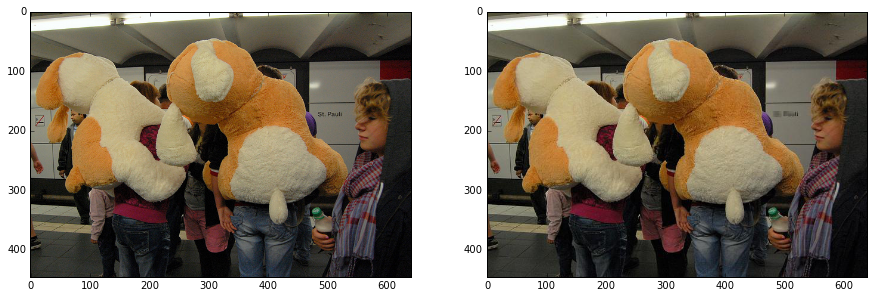

In [14]:
get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"))


Total:	15980;		Mean:		0.809745;	None-ones:	5320(33.29%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.299980


[125817]Images with lowest scores:

	Score:1.0;

	Original Caption:
		a group of people standing next to each other;
	Ablation Caption:
		a group of people standing next to each other;
	Annotated Captions:

		1. A group of people standing around to very large stuffed animals.

		2. People standing around with large stuffed dogs on their backs.

		3. Two people standing in a group with stuffed animals on their backs.

		4. Two people with large stuffed animals on their backs.

		5. Two people carrying two huge stuffed animals on their backs.

blackout
Ablating image 1/1


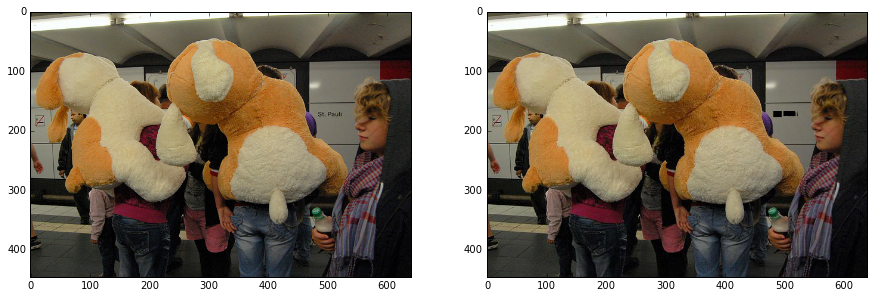

In [15]:
get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"))


Total:	15980;		Mean:		0.902979;	None-ones:	2882(18.04%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.227583


[125817]Images with lowest scores:

	Score:1.0;

	Original Caption:
		a group of people standing next to each other;
	Ablation Caption:
		a group of people standing next to each other;
	Annotated Captions:

		1. A group of people standing around to very large stuffed animals.

		2. People standing around with large stuffed dogs on their backs.

		3. Two people standing in a group with stuffed animals on their backs.

		4. Two people with large stuffed animals on their backs.

		5. Two people carrying two huge stuffed animals on their backs.

gaussian
Ablating image 1/1


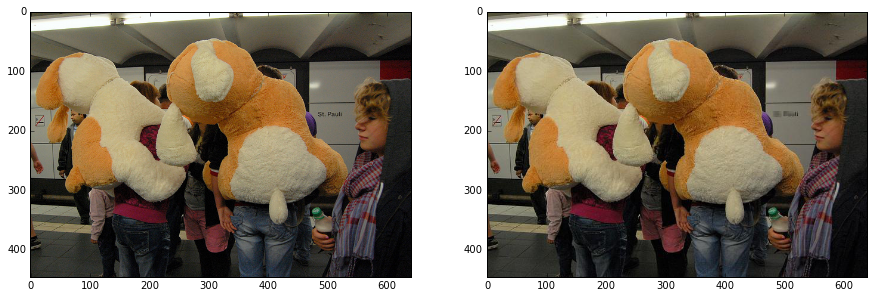

In [16]:
get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"))


Total:	5556;		Mean:		0.829445;	None-ones:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410


[14988]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a book shelf filled with lots of books;
	Ablation Caption:
		a picture of a person holding a cell phone;
	Annotated Captions:

		1. There is an image of books and toys on the shelf

		2. The books are on display next to the toys.

		3. a display with books and a bus sitting together

		4. A small bus with a dinosaur on top of it

		5. A collection of mostly pink toys and books.

gaussian
Ablating image 1/1


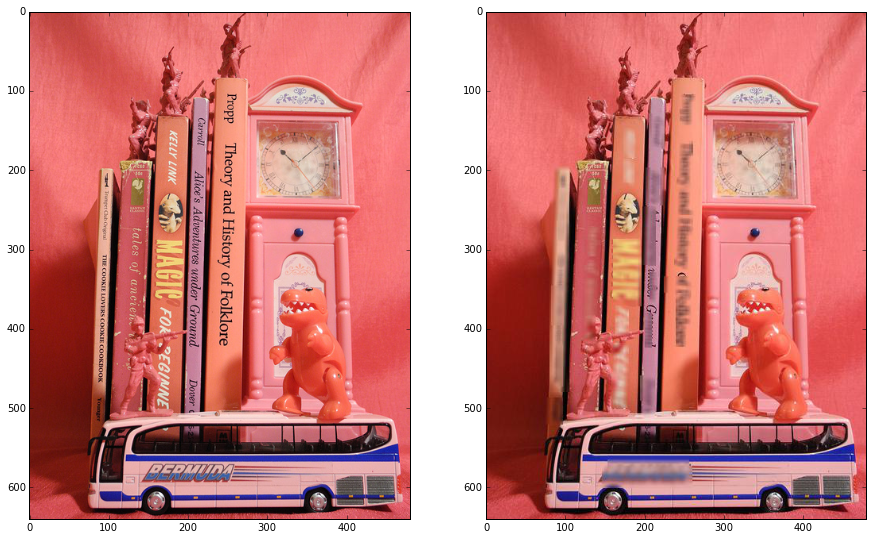

[259297]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a tray of food with a hot dog and fries;
	Ablation Caption:
		a sandwich and a drink on a table;
	Annotated Captions:

		1. there are many different things that are at this market

		2. Assortment of hot dogs covered in pasta noodles.

		3. A few sandwiches with noodles on them in a store.

		4. A collection of premade sandwiches for sale on a shelf.

		5. A sub with a sandwich behind it, and a salad on the other side.

gaussian
Ablating image 1/1


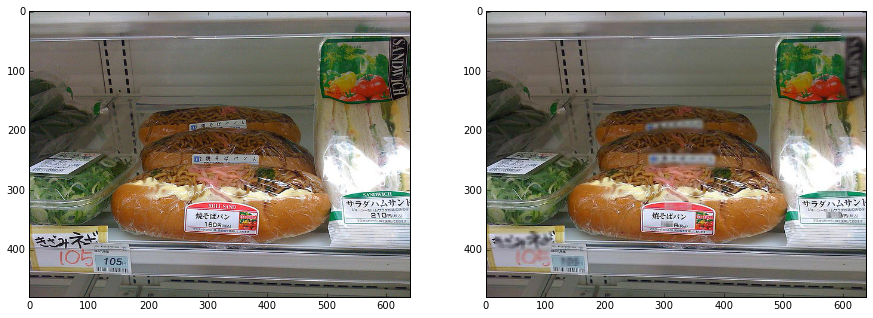

In [12]:
get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"))


Total:	5556;		Mean:		0.829445;	None-ones:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410


[14988]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a book shelf filled with lots of books;
	Ablation Caption:
		a picture of a person holding a cell phone;
	Annotated Captions:

		1. There is an image of books and toys on the shelf

		2. The books are on display next to the toys.

		3. a display with books and a bus sitting together

		4. A small bus with a dinosaur on top of it

		5. A collection of mostly pink toys and books.

blackout
Ablating image 1/1


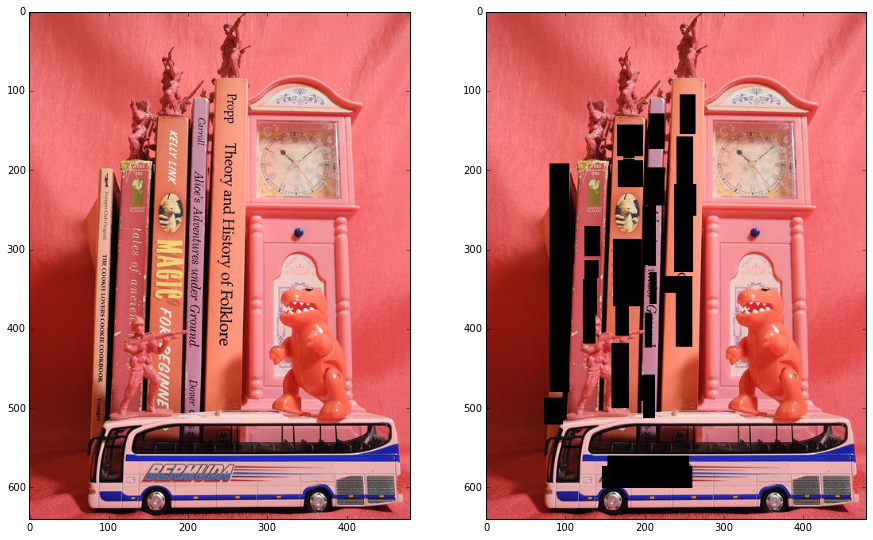

In [10]:
get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"))


Total:	5556;		Mean:		0.852893;	None-ones:	1475(26.55%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.271832


[521525]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a piece of bread with a bite taken out of it;
	Ablation Caption:
		a donut sitting on top of a white plate;
	Annotated Captions:

		1. A frosted cookie sitting on top of a diagram.

		2. A paper with a cookie on it as well as a marker.

		3. A cookie sitting on pen drawings next to a black pen.

		4. a cookie with frosting on it on top of a paper with drawing on it

		5. A pen and a cake on some paper.

median
Ablating image 1/1


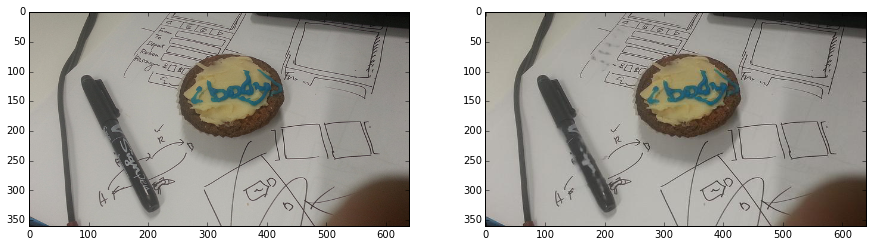

In [8]:
get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"))


Total:	82081;		Mean:		0.380484;	None-ones:	68238(83.13%)
Median:	0.250000;	Median(H):	0.250000;	Median(L):	0.250000;
Max:	1.000000;	Min:		0.000000;	Std:		0.344731


[182974]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a bedroom with a bed and a window;
	Ablation Caption:
		a view of a plane flying in the sky;
	Annotated Captions:

		1. A picture mounted to a wall above a wooden table.

		2. A desk and picture up on a wall in a room.

		3. Table against a wall, containing small cow figurines.

		4. A small table against a red wall, next to red curtains.

		5. A red wood night stand with two grey cow statues, and a pink wall behind it.

destroy
Ablating image 1/1 with id 182974 


/Users/zhuyifan/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /Users/zhuyifan/Documents/2016 Summer Research/textmatters/coco-text/../tmp/destroy_COCO_train2014_000000182974.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


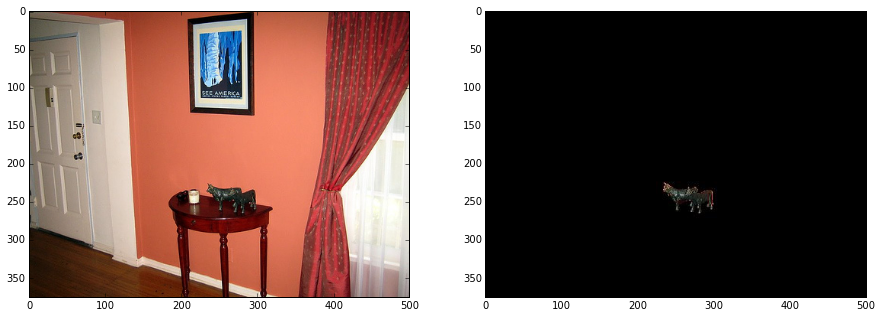

In [9]:
get_expr_summary(log_file=os.path.join("stats","no_text","bgdestroy.pkl"))
# get_expr_summary(log_file='no_text_has_instances.pkl')


Total:	2317;		Mean:		0.503394;	None-ones:	1510(65.17%)
Median:	0.333333;	Median(H):	0.333333;	Median(L):	0.333333;
Max:	1.000000;	Min:		0.000000;	Std:		0.398041


[299811]Images with lowest scores:

	Score:0.25;

	Original Caption:
		a bathroom with a toilet and a sink;
	Ablation Caption:
		a white toilet sitting in a bathroom next to a wall;
	Annotated Captions:

		1. A white bathroom toilet with a towel hanging above it.

		2. A narrow bathroom with a white toilet and a black towel hanging from a rack.

		3. A white toilet sitting in a bathroom under a blue towel.

		4. A white toilet is not being used in the bathroom.

		5. A view through a narrow door into a small bathroom.

median_bg
Ablating image 1/1 with id 299811 


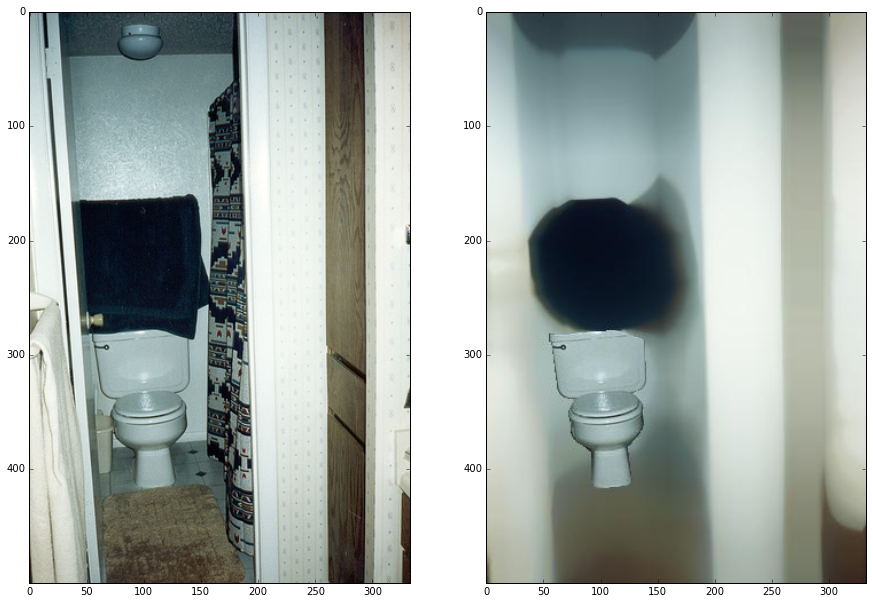

In [22]:
get_expr_summary(log_file=os.path.join('stats','toilet_median_bg', 'toilet_only_median_bg_71.pkl'), num=1,rand=True)